In [1]:
import pandas as pd
import settings as settings
import warnings
import numpy as np
import umap
import spikeinterface.full as si
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, Isomap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate
import joblib as jl
import cebra.datasets
from cebra import CEBRA
import cebra.integrations.plotly
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import sklearn.metrics
from matplotlib.collections import LineCollection
from Helpers.array_utility import list_of_list_to_1d_numpy_array
import sklearn.metrics
from P3_CurrentAnalysis.LDM.cebra_helper import *
from Helpers import plot_utility

project_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"


2024-09-02 17:22:03.894018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 17:22:04.035426: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 17:22:04.042791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-02 17:22:04.042810: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
def get_data(vr_name, of_name):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    vr_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    of_path = f"{project_path}{mouse}/{day}/of/{of_name}/processed/kilosort4/spikes.pkl"
    sorting_analyzer_path = f"{project_path}{mouse}/{day}/ephys/sorting_analyzer"
    spike_data_vr = pd.read_pickle(vr_path); spike_data_vr["firing_times_vr"] = spike_data_vr["firing_times"]
    spike_data_of = pd.read_pickle(of_path)
    spike_data = pd.merge(spike_data_vr, spike_data_of, on="cluster_id")

    sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
    ulc = sorting_analyzer.get_extension("unit_locations")
    unit_locations = ulc.get_data(outputs="by_unit")
    spike_data['unit_location_x'] = (spike_data.index.map(lambda unit: unit_locations[unit][0])*-1)+750+40
    spike_data['unit_location_y'] = spike_data.index.map(lambda unit: unit_locations[unit][1])
    spike_data['unit_location_z'] = spike_data.index.map(lambda unit: unit_locations[unit][2])

    position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/position_data.csv"
    processed_position_path = f"{project_path}{mouse}/{day}/vr/{vr_name}/processed/processed_position_data.pkl"
    position_data = pd.read_csv(position_path)
    processed_position_data = pd.read_pickle(processed_position_path)

    spike_data = spike_data[(spike_data["snr_x"] > 1) & 
                            (spike_data["mean_firing_rate_x"] > 0.5) & 
                            (spike_data["rp_contamination_x"] < 0.9)]

    return spike_data, position_data, processed_position_data

#### test models using all data

In [ ]:
of_session_base_names = ["M21_D23_2024-05-25_16-07-17_OF1"]
vr_session_base_names = ["M21_D23_2024-05-25_16-54-12_VR1"]


for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    spike_data, position_data, processed_position_data = get_data(vr_name=vr_name, of_name=of_name)
    
    fr_time_binned = extract_fr_column(spike_data, column="fr_time_binned_smoothed")
    x_time_binned = extract_fr_column(spike_data, column="fr_time_binned_bin_centres")
    # flip axis so its in form (n_samples, n_features)
    fr_time_binned = np.transpose(fr_time_binned)
    x_time_binned = np.transpose(x_time_binned)
    behavioural_data =  computer_behaviour_kinematics(position_data, 
                                                      xnew_length=len(x_time_binned[:,0]),
                                                      xnew_time_bin_size=settings.time_bin_size, 
                                                      track_length=200)

    x_position_cm = np.array(behavioural_data["x_position_cm"])
    speed = np.array(behavioural_data["speed"]); speed = speed/np.max(speed)
    acceleration = np.array(behavioural_data["acceleration"])
    trial_numbers = np.array(behavioural_data["trial_numbers"])
    time_seconds = np.array(behavioural_data["time_seconds"])
    x_position_cm_xy_cyc = encode_1d_to_2d(positions=x_position_cm)
    x_position_cm_x_cyc = x_position_cm_xy_cyc[:,0]
    x_position_cm_y_cyc = x_position_cm_xy_cyc[:,1]
    all_behaviour = np.stack([x_position_cm, x_position_cm_x_cyc, x_position_cm_y_cyc, 
                              speed, acceleration, trial_numbers, time_seconds], axis=0)
    all_behaviour = np.transpose(all_behaviour)

    max_i = 11000
    dims = 32  # here, we set as a variable for hypothesis testing below.

    # build behaviour models
    position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                           temperature=10, output_dimension=dims, max_iterations=max_i,
                           distance='cosine', conditional='time_delta',  device='cuda_if_available',
                           verbose=True, time_offsets=1)
    position_speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)
    speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)


    # build shuffled behaviour models
    shuf_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                                    temperature=10, output_dimension=dims, max_iterations=max_i,
                                    distance='cosine', conditional='time_delta',  device='cuda_if_available',
                                    verbose=True, time_offsets=1)
    shuf_position_speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)
    shuf_speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)

    # make training and testing data
    neural_train, neural_test, label_train, label_test = split_data(fr_time_binned, all_behaviour, 0.2)

    # train models
    position_model.fit(neural_train, label_train[:, 1:3])
    position_speed_model.fit(neural_train, label_train[:, 1:4])
    speed_model.fit(neural_train, label_train[:, 4])
    shuf_position_model.fit(neural_train, np.random.permutation(label_train[:, 1:3]))
    shuf_position_speed_model.fit(neural_train, np.random.permutation(label_train[:, 1:4]))
    shuf_speed_model.fit(neural_train, np.random.permutation(label_train[:, 4]))

    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(111)
    ax.plot(position_speed_model.state_dict_['loss'], c='orange', alpha=1, label='position & speed')
    ax.plot(position_model.state_dict_['loss'], c='red', alpha=0.3, label='position')
    ax.plot(speed_model.state_dict_['loss'], c='yellow', alpha=0.6, label='speed')
    ax.plot(shuf_position_speed_model.state_dict_['loss'], c='gray', alpha=1, label='shuffled position & speed')
    ax.plot(shuf_position_model.state_dict_['loss'], c='gray', alpha=0.3, label='shuffled position')
    ax.plot(shuf_speed_model.state_dict_['loss'], c='gray', alpha=0.6, label='shuffled speed')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('InfoNCE Loss')
    plt.legend(bbox_to_anchor=(0.5, 0.3), frameon=False)
    plt.show()

    #plot embeddings
    position_embedding = position_model.transform(fr_time_binned)
    position_speed_embedding = position_speed_model.transform(fr_time_binned)
    speed_embedding = speed_model.transform(fr_time_binned)
    shuf_position_embedding = shuf_position_model.transform(fr_time_binned)
    shuf_position_speed_embedding = shuf_position_speed_model.transform(fr_time_binned)
    shuf_speed_embedding = shuf_speed_model.transform(fr_time_binned)
    
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, position_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax2 = plot_embeddings(ax2, position_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax3 = plot_embeddings(ax3, speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax4 = plot_embeddings(ax4, shuf_position_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax5 = plot_embeddings(ax5, shuf_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax6 = plot_embeddings(ax6, shuf_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)

    ax1.set_title('Position')
    ax2.set_title('Position + Speed')
    ax3.set_title('Speed')
    plt.show()
    
    # plot decoding of position model
    position_train = position_model.transform(neural_train)
    position_test = position_model.transform(neural_test)

    position_decoded_train = decoding_pos(position_train, position_train, label_train[:, 1:3])
    position_decoded_test = decoding_pos(position_train, position_test, label_train[:, 1:3])

    original_train = decode_2d_to_1d(label_train[:,1:3])
    original_test = decode_2d_to_1d(label_test[:,1:3])
    position_decoded_train_1d = decode_2d_to_1d(position_decoded_train)
    position_decoded_test_1d = decode_2d_to_1d(position_decoded_test)

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(label_train[:n_samples, 6], original_train[:n_samples], c='gray', s=1)
    ax.scatter(label_train[:n_samples, 6], position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title("Train data")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(label_test[:n_samples, 6], original_test[:n_samples], c='gray', s=1)
    ax.scatter(label_test[:n_samples, 6], position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title("Test data")
    plt.show()



#### now for only visual cortex data 


In [ ]:
of_session_base_names = ["M21_D23_2024-05-25_16-07-17_OF1"]
vr_session_base_names = ["M21_D23_2024-05-25_16-54-12_VR1"]


for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    spike_data, position_data, processed_position_data = get_data(vr_name=vr_name, of_name=of_name)
    spike_data = spike_data[spike_data["unit_location_y"] > 2200]

    fr_time_binned = extract_fr_column(spike_data, column="fr_time_binned_smoothed")
    x_time_binned = extract_fr_column(spike_data, column="fr_time_binned_bin_centres")
    # flip axis so its in form (n_samples, n_features)
    fr_time_binned = np.transpose(fr_time_binned)
    x_time_binned = np.transpose(x_time_binned)
    behavioural_data =  computer_behaviour_kinematics(position_data, 
                                                      xnew_length=len(x_time_binned[:,0]),
                                                      xnew_time_bin_size=settings.time_bin_size, 
                                                      track_length=200)

    x_position_cm = np.array(behavioural_data["x_position_cm"])
    speed = np.array(behavioural_data["speed"]); speed = speed/np.max(speed)
    acceleration = np.array(behavioural_data["acceleration"])
    trial_numbers = np.array(behavioural_data["trial_numbers"])
    time_seconds = np.array(behavioural_data["time_seconds"])
    x_position_cm_xy_cyc = encode_1d_to_2d(positions=x_position_cm)
    x_position_cm_x_cyc = x_position_cm_xy_cyc[:,0]
    x_position_cm_y_cyc = x_position_cm_xy_cyc[:,1]
    all_behaviour = np.stack([x_position_cm, x_position_cm_x_cyc, x_position_cm_y_cyc, 
                              speed, acceleration, trial_numbers, time_seconds], axis=0)
    all_behaviour = np.transpose(all_behaviour)

    max_i = 11000
    dims = 32  # here, we set as a variable for hypothesis testing below.

    # build behaviour models
    position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                           temperature=10, output_dimension=dims, max_iterations=max_i,
                           distance='cosine', conditional='time_delta',  device='cuda_if_available',
                           verbose=True, time_offsets=1)
    position_speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)
    speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)


    # build shuffled behaviour models
    shuf_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                                    temperature=10, output_dimension=dims, max_iterations=max_i,
                                    distance='cosine', conditional='time_delta',  device='cuda_if_available',
                                    verbose=True, time_offsets=1)
    shuf_position_speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)
    shuf_speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)

    # make training and testing data
    neural_train, neural_test, label_train, label_test = split_data(fr_time_binned, all_behaviour, 0.2)

    # train models
    position_model.fit(neural_train, label_train[:, 1:3])
    position_speed_model.fit(neural_train, label_train[:, 1:4])
    speed_model.fit(neural_train, label_train[:, 4])
    shuf_position_model.fit(neural_train, np.random.permutation(label_train[:, 1:3]))
    shuf_position_speed_model.fit(neural_train, np.random.permutation(label_train[:, 1:4]))
    shuf_speed_model.fit(neural_train, np.random.permutation(label_train[:, 4]))

    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(111)
    ax.plot(position_speed_model.state_dict_['loss'], c='orange', alpha=1, label='position & speed')
    ax.plot(position_model.state_dict_['loss'], c='red', alpha=0.3, label='position')
    ax.plot(speed_model.state_dict_['loss'], c='yellow', alpha=0.6, label='speed')
    ax.plot(shuf_position_speed_model.state_dict_['loss'], c='gray', alpha=1, label='shuffled position & speed')
    ax.plot(shuf_position_model.state_dict_['loss'], c='gray', alpha=0.3, label='shuffled position')
    ax.plot(shuf_speed_model.state_dict_['loss'], c='gray', alpha=0.6, label='shuffled speed')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('InfoNCE Loss')
    plt.legend(bbox_to_anchor=(0.5, 0.3), frameon=False)
    plt.show()

    #plot embeddings
    position_embedding = position_model.transform(fr_time_binned)
    position_speed_embedding = position_speed_model.transform(fr_time_binned)
    speed_embedding = speed_model.transform(fr_time_binned)
    shuf_position_embedding = shuf_position_model.transform(fr_time_binned)
    shuf_position_speed_embedding = shuf_position_speed_model.transform(fr_time_binned)
    shuf_speed_embedding = shuf_speed_model.transform(fr_time_binned)
    
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, position_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax2 = plot_embeddings(ax2, position_speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax3 = plot_embeddings(ax3, speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax4 = plot_embeddings(ax4, shuf_position_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax5 = plot_embeddings(ax5, shuf_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax6 = plot_embeddings(ax6, shuf_speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax1.set_title('Position')
    ax2.set_title('Position + Speed')
    ax3.set_title('Speed')
    plt.show()

    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, position_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax2 = plot_embeddings(ax2, position_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax3 = plot_embeddings(ax3, speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax4 = plot_embeddings(ax4, shuf_position_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax5 = plot_embeddings(ax5, shuf_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax6 = plot_embeddings(ax6, shuf_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax1.set_title('Position')
    ax2.set_title('Position + Speed')
    ax3.set_title('Speed')
    plt.show()

    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, position_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax2 = plot_embeddings(ax2, position_speed_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax3 = plot_embeddings(ax3, speed_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax4 = plot_embeddings(ax4, shuf_position_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax5 = plot_embeddings(ax5, shuf_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax6 = plot_embeddings(ax6, shuf_speed_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax1.set_title('Position')
    ax2.set_title('Position + Speed')
    ax3.set_title('Speed')
    plt.show()
    
    # plot decoding of position model
    position_train = position_model.transform(neural_train)
    position_test = position_model.transform(neural_test)

    position_decoded_train = decoding_pos(position_train, position_train, label_train[:, 1:3])
    position_decoded_test = decoding_pos(position_train, position_test, label_train[:, 1:3])
    original_train = decode_2d_to_1d(label_train[:,1:3])
    original_test = decode_2d_to_1d(label_test[:,1:3])
    position_decoded_train_1d = decode_2d_to_1d(position_decoded_train)
    position_decoded_test_1d = decode_2d_to_1d(position_decoded_test)

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(label_train[:n_samples, 6], original_train[:n_samples], c='gray', s=1)
    ax.scatter(label_train[:n_samples, 6], position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title("Train data")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(label_test[:n_samples, 6], original_test[:n_samples], c='gray', s=1)
    ax.scatter(label_test[:n_samples, 6], position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title("Test data")
    plt.show()



#### now only using entorhinal data

In [ ]:
of_session_base_names = ["M21_D23_2024-05-25_16-07-17_OF1"]
vr_session_base_names = ["M21_D23_2024-05-25_16-54-12_VR1"]


for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    spike_data, position_data, processed_position_data = get_data(vr_name=vr_name, of_name=of_name)
    spike_data = spike_data[spike_data["unit_location_y"] < 2200]

    fr_time_binned = extract_fr_column(spike_data, column="fr_time_binned_smoothed")
    x_time_binned = extract_fr_column(spike_data, column="fr_time_binned_bin_centres")
    # flip axis so its in form (n_samples, n_features)
    fr_time_binned = np.transpose(fr_time_binned)
    x_time_binned = np.transpose(x_time_binned)
    behavioural_data =  computer_behaviour_kinematics(position_data, 
                                                      xnew_length=len(x_time_binned[:,0]),
                                                      xnew_time_bin_size=settings.time_bin_size, 
                                                      track_length=200)

    x_position_cm = np.array(behavioural_data["x_position_cm"])
    speed = np.array(behavioural_data["speed"]); speed = speed/np.max(speed)
    acceleration = np.array(behavioural_data["acceleration"])
    trial_numbers = np.array(behavioural_data["trial_numbers"])
    time_seconds = np.array(behavioural_data["time_seconds"])
    x_position_cm_xy_cyc = encode_1d_to_2d(positions=x_position_cm)
    x_position_cm_x_cyc = x_position_cm_xy_cyc[:,0]
    x_position_cm_y_cyc = x_position_cm_xy_cyc[:,1]
    all_behaviour = np.stack([x_position_cm, x_position_cm_x_cyc, x_position_cm_y_cyc, 
                              speed, acceleration, trial_numbers, time_seconds], axis=0)
    all_behaviour = np.transpose(all_behaviour)

    max_i = 11000
    dims = 32  # here, we set as a variable for hypothesis testing below.

    # build behaviour models
    position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                           temperature=10, output_dimension=dims, max_iterations=max_i,
                           distance='cosine', conditional='time_delta',  device='cuda_if_available',
                           verbose=True, time_offsets=1)
    position_speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)
    speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)


    # build shuffled behaviour models
    shuf_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                                    temperature=10, output_dimension=dims, max_iterations=max_i,
                                    distance='cosine', conditional='time_delta',  device='cuda_if_available',
                                    verbose=True, time_offsets=1)
    shuf_position_speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)
    shuf_speed_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)

    # make training and testing data
    neural_train, neural_test, label_train, label_test = split_data(fr_time_binned, all_behaviour, 0.2)

    # train models
    position_model.fit(neural_train, label_train[:, 1:3])
    position_speed_model.fit(neural_train, label_train[:, 1:4])
    speed_model.fit(neural_train, label_train[:, 4])
    shuf_position_model.fit(neural_train, np.random.permutation(label_train[:, 1:3]))
    shuf_position_speed_model.fit(neural_train, np.random.permutation(label_train[:, 1:4]))
    shuf_speed_model.fit(neural_train, np.random.permutation(label_train[:, 4]))

    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(111)
    ax.plot(position_speed_model.state_dict_['loss'], c='orange', alpha=1, label='position & speed')
    ax.plot(position_model.state_dict_['loss'], c='red', alpha=0.3, label='position')
    ax.plot(speed_model.state_dict_['loss'], c='yellow', alpha=0.6, label='speed')
    ax.plot(shuf_position_speed_model.state_dict_['loss'], c='gray', alpha=1, label='shuffled position & speed')
    ax.plot(shuf_position_model.state_dict_['loss'], c='gray', alpha=0.3, label='shuffled position')
    ax.plot(shuf_speed_model.state_dict_['loss'], c='gray', alpha=0.6, label='shuffled speed')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('InfoNCE Loss')
    plt.legend(bbox_to_anchor=(0.5, 0.3), frameon=False)
    plt.show()

    #plot embeddings
    position_embedding = position_model.transform(fr_time_binned)
    position_speed_embedding = position_speed_model.transform(fr_time_binned)
    speed_embedding = speed_model.transform(fr_time_binned)
    shuf_position_embedding = shuf_position_model.transform(fr_time_binned)
    shuf_position_speed_embedding = shuf_position_speed_model.transform(fr_time_binned)
    shuf_speed_embedding = shuf_speed_model.transform(fr_time_binned)
    

    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, position_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax2 = plot_embeddings(ax2, position_speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax3 = plot_embeddings(ax3, speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax4 = plot_embeddings(ax4, shuf_position_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax5 = plot_embeddings(ax5, shuf_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax6 = plot_embeddings(ax6, shuf_speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax1.set_title('Position')
    ax2.set_title('Position + Speed')
    ax3.set_title('Speed')
    plt.show()

    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, position_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax2 = plot_embeddings(ax2, position_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax3 = plot_embeddings(ax3, speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax4 = plot_embeddings(ax4, shuf_position_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax5 = plot_embeddings(ax5, shuf_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax6 = plot_embeddings(ax6, shuf_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax1.set_title('Position')
    ax2.set_title('Position + Speed')
    ax3.set_title('Speed')
    plt.show()

    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, position_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax2 = plot_embeddings(ax2, position_speed_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax3 = plot_embeddings(ax3, speed_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax4 = plot_embeddings(ax4, shuf_position_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax5 = plot_embeddings(ax5, shuf_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax6 = plot_embeddings(ax6, shuf_speed_embedding, x_position_cm, cmap="track", viewing_angle=3)
    ax1.set_title('Position')
    ax2.set_title('Position + Speed')
    ax3.set_title('Speed')
    plt.show()
    
    # plot decoding of position model
    position_train = position_model.transform(neural_train)
    position_test = position_model.transform(neural_test)

    position_decoded_train = decoding_pos(position_train, position_train, label_train[:, 1:3])
    position_decoded_test = decoding_pos(position_train, position_test, label_train[:, 1:3])
    original_train = decode_2d_to_1d(label_train[:,1:3])
    original_test = decode_2d_to_1d(label_test[:,1:3])
    position_decoded_train_1d = decode_2d_to_1d(position_decoded_train)
    position_decoded_test_1d = decode_2d_to_1d(position_decoded_test)

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(label_train[:n_samples, 6], original_train[:n_samples], c='gray', s=1)
    ax.scatter(label_train[:n_samples, 6], position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title("Train data")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(label_test[:n_samples, 6], original_test[:n_samples], c='gray', s=1)
    ax.scatter(label_test[:n_samples, 6], position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title("Test data")
    plt.show()



#### now compare entorhinal model vs visual model

pos: -0.0992 neg:  6.2409 total:  6.1417 temperature:  10.0000: 100%|██████████| 11000/11000 [14:42<00:00, 12.46it/s]
pos: -0.0990 neg:  6.2408 total:  6.1419 temperature:  10.0000: 100%|██████████| 11000/11000 [13:35<00:00, 13.49it/s]


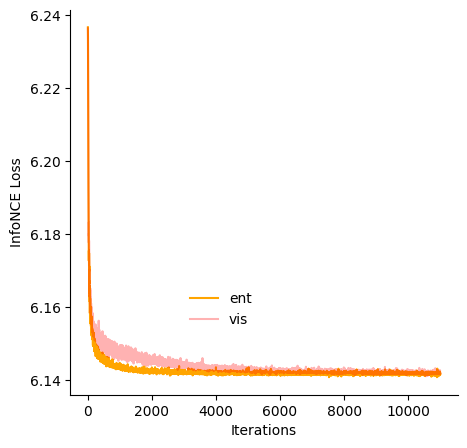

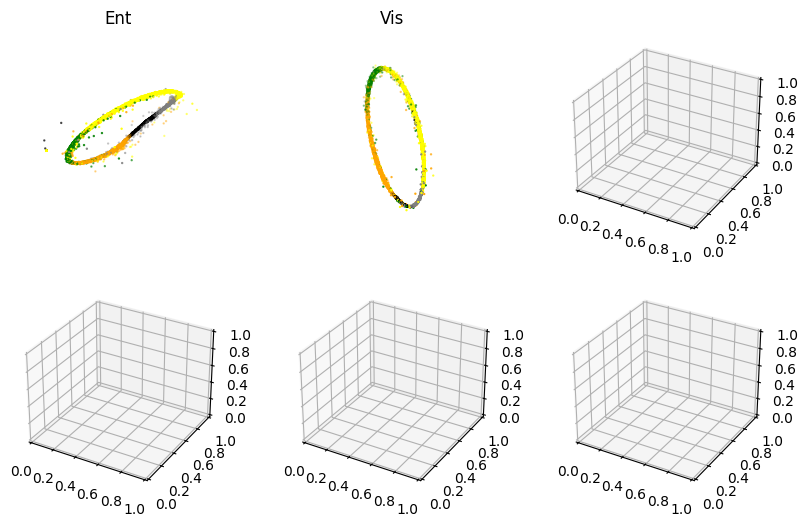

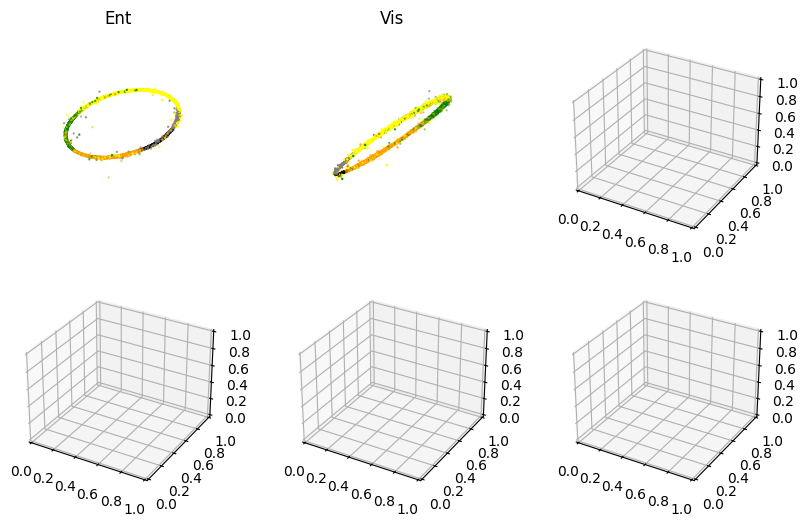

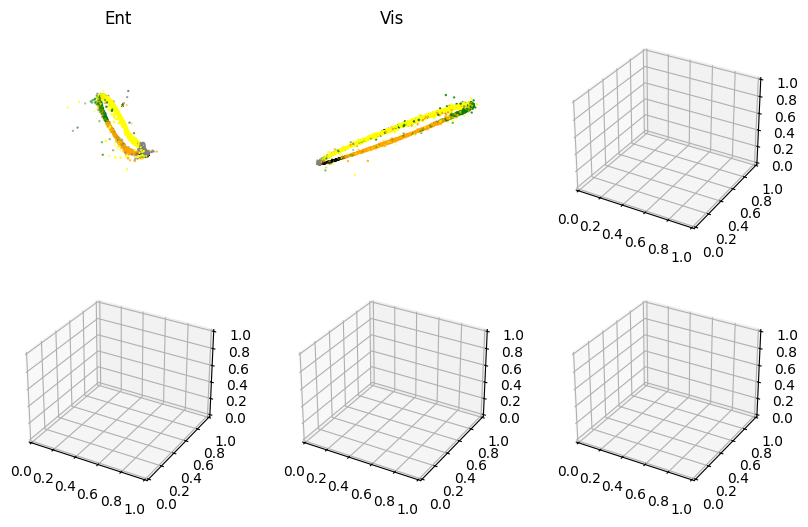

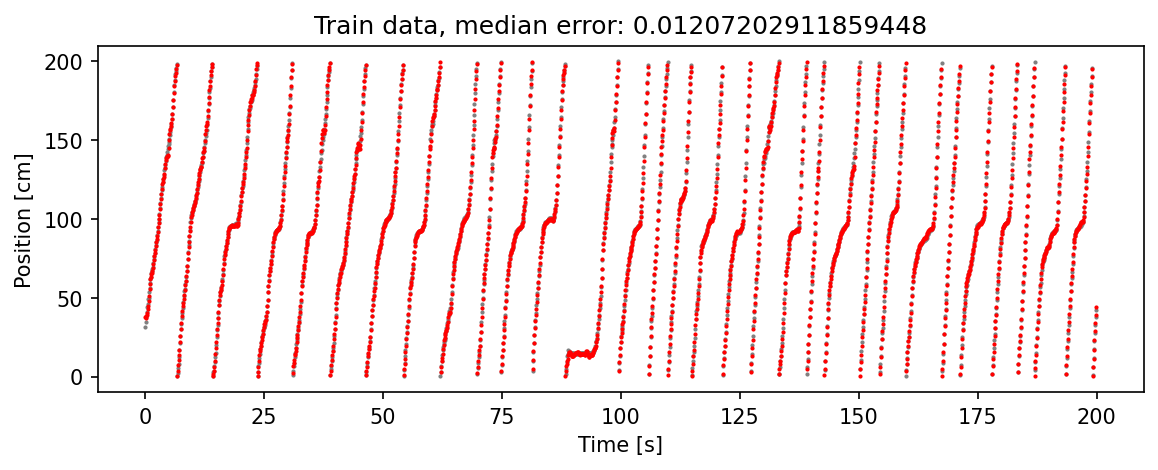

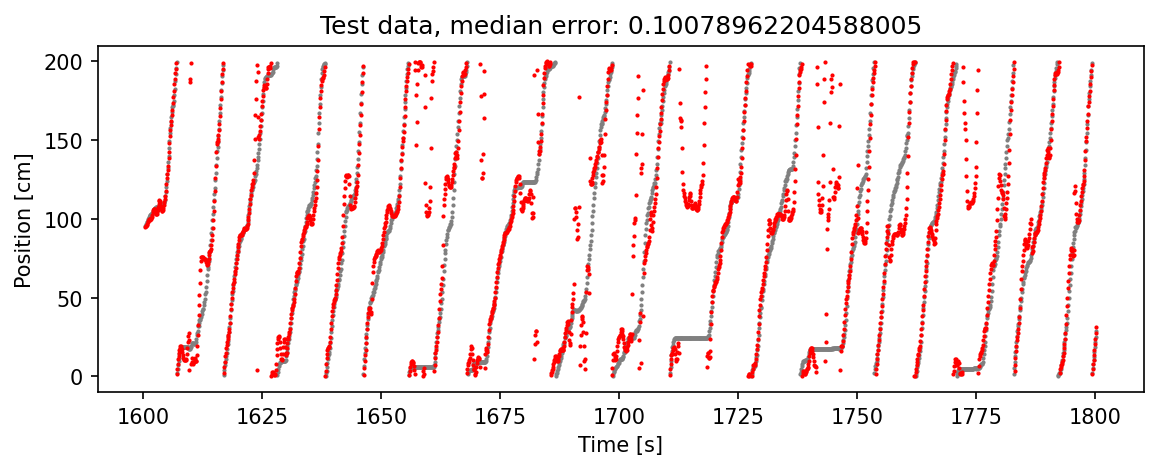

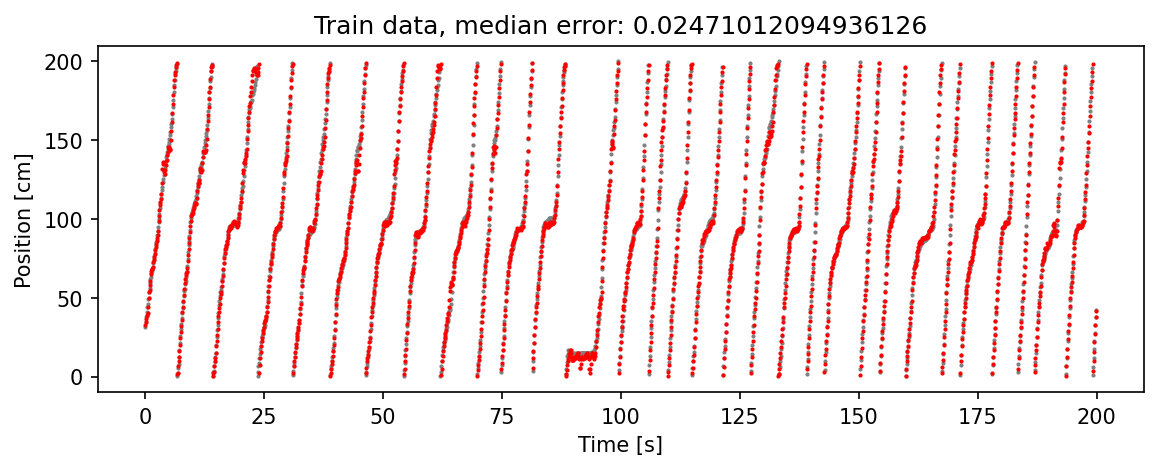

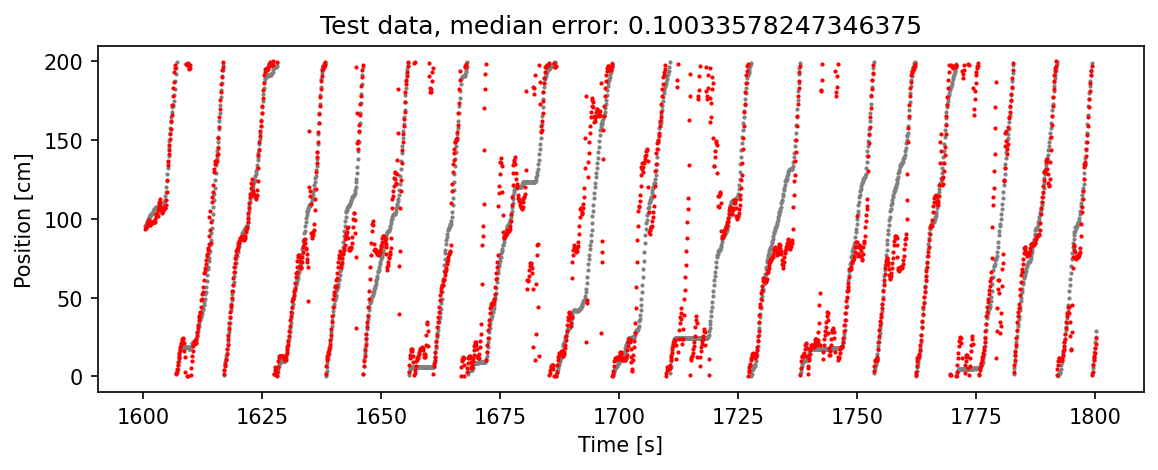

In [4]:
of_session_base_names = ["M21_D23_2024-05-25_16-07-17_OF1"]
vr_session_base_names = ["M21_D23_2024-05-25_16-54-12_VR1"]


for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    spike_data, position_data, processed_position_data = get_data(vr_name=vr_name, of_name=of_name)
    entorhinal_data = spike_data[spike_data["unit_location_y"] < 2200]
    visual_data = spike_data[spike_data["unit_location_y"] > 2200]

    entorhinal_fr_time_binned = extract_fr_column(entorhinal_data, column="fr_time_binned_smoothed")
    entorhinal_x_time_binned = extract_fr_column(entorhinal_data, column="fr_time_binned_bin_centres")
    entorhinal_fr_time_binned = np.transpose(entorhinal_fr_time_binned)
    entorhinal_x_time_binned = np.transpose(entorhinal_x_time_binned)

    visual_fr_time_binned = extract_fr_column(visual_data, column="fr_time_binned_smoothed")
    visual_x_time_binned = extract_fr_column(visual_data, column="fr_time_binned_bin_centres")
    visual_fr_time_binned = np.transpose(visual_fr_time_binned)
    visual_x_time_binned = np.transpose(visual_x_time_binned)

    behavioural_data =  computer_behaviour_kinematics(position_data, 
                                                      xnew_length=len(visual_x_time_binned[:,0]),
                                                      xnew_time_bin_size=settings.time_bin_size, 
                                                      track_length=200)

    x_position_cm = np.array(behavioural_data["x_position_cm"])
    speed = np.array(behavioural_data["speed"]); speed = speed/np.max(speed)
    acceleration = np.array(behavioural_data["acceleration"])
    trial_numbers = np.array(behavioural_data["trial_numbers"])
    time_seconds = np.array(behavioural_data["time_seconds"])
    x_position_cm_xy_cyc = encode_1d_to_2d(positions=x_position_cm)
    x_position_cm_x_cyc = x_position_cm_xy_cyc[:,0]
    x_position_cm_y_cyc = x_position_cm_xy_cyc[:,1]
    all_behaviour = np.stack([x_position_cm, x_position_cm_x_cyc, x_position_cm_y_cyc, 
                              speed, acceleration, trial_numbers, time_seconds], axis=0)
    all_behaviour = np.transpose(all_behaviour)

    max_i = 11000
    dims = 32  # here, we set as a variable for hypothesis testing below.

    # build entorhinal behaviour models
    entorhinal_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                           temperature=10, output_dimension=dims, max_iterations=max_i,
                           distance='cosine', conditional='time_delta',  device='cuda_if_available',
                           verbose=True, time_offsets=1)

    visual_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)

    # make training and testing data
    entorhinal_neural_train, entorhinal_neural_test, entorhinal_label_train, entorhinal_label_test = split_data(entorhinal_fr_time_binned, all_behaviour, 0.2)
    visual_neural_train, visual_neural_test, visual_label_train, visual_label_test = split_data(visual_fr_time_binned, all_behaviour, 0.2)

    # train models
    entorhinal_position_model.fit(entorhinal_neural_train, entorhinal_label_train[:, 1:3])
    visual_position_model.fit(visual_neural_train, visual_label_train[:, 1:4])
    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(111)
    ax.plot(entorhinal_position_model.state_dict_['loss'], c='orange', alpha=1, label='ent')
    ax.plot(visual_position_model.state_dict_['loss'], c='red', alpha=0.3, label='vis')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('InfoNCE Loss')
    plt.legend(bbox_to_anchor=(0.5, 0.3), frameon=False)
    plt.show()

    #plot embeddings
    entorhinal_position_embedding = entorhinal_position_model.transform(entorhinal_fr_time_binned)
    visual_position_speed_embedding = visual_position_model.transform(visual_fr_time_binned)
    
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=0)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=0)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()

    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()
    
    # plot decoding of entorhinal_ position model
    entorhinal_position_train = entorhinal_position_model.transform(entorhinal_neural_train)
    entorhinal_position_test = entorhinal_position_model.transform(entorhinal_neural_test)

    entorhinal_position_decoded_train = decoding_pos(entorhinal_position_train, entorhinal_position_train, entorhinal_label_train[:, 1:3])
    entorhinal_position_decoded_test = decoding_pos(entorhinal_position_train, entorhinal_position_test, entorhinal_label_train[:, 1:3])
    entorhinal_original_train = decode_2d_to_1d(entorhinal_label_train[:,1:3])
    entorhinal_original_test = decode_2d_to_1d(entorhinal_label_test[:,1:3])
    entorhinal_position_decoded_train_1d = decode_2d_to_1d(entorhinal_position_decoded_train)
    entorhinal_position_decoded_test_1d = decode_2d_to_1d(entorhinal_position_decoded_test)

    entorhinal_pos_train_err = np.median(abs(entorhinal_position_decoded_train - entorhinal_label_train[:,1:3]))
    entorhinal_pos_test_err = np.median(abs(entorhinal_position_decoded_test - entorhinal_label_test[:,1:3]))


    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(entorhinal_label_train[:n_samples, 6], entorhinal_original_train[:n_samples], c='gray', s=1)
    ax.scatter(entorhinal_label_train[:n_samples, 6], entorhinal_position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Train data, median error: {entorhinal_pos_train_err}")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(entorhinal_label_test[:n_samples, 6], entorhinal_original_test[:n_samples], c='gray', s=1)
    ax.scatter(entorhinal_label_test[:n_samples, 6], entorhinal_position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Test data, median error: {entorhinal_pos_test_err}")
    plt.show()

    
    # plot decoding of entorhinal_ position model
    visual_position_train = visual_position_model.transform(visual_neural_train)
    visual_position_test = visual_position_model.transform(visual_neural_test)

    visual_position_decoded_train = decoding_pos(visual_position_train, visual_position_train, visual_label_train[:, 1:3])
    visual_position_decoded_test = decoding_pos(visual_position_train, visual_position_test, visual_label_train[:, 1:3])
    visual_original_train = decode_2d_to_1d(visual_label_train[:,1:3])
    visual_original_test = decode_2d_to_1d(visual_label_test[:,1:3])
    visual_position_decoded_train_1d = decode_2d_to_1d(visual_position_decoded_train)
    visual_position_decoded_test_1d = decode_2d_to_1d(visual_position_decoded_test)
    
    visual_pos_train_err = np.median(abs(visual_position_decoded_train - visual_label_train[:,1:3]))
    visual_pos_test_err = np.median(abs(visual_position_decoded_test - visual_label_test[:,1:3]))

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(visual_label_train[:n_samples, 6], visual_original_train[:n_samples], c='gray', s=1)
    ax.scatter(visual_label_train[:n_samples, 6], visual_position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Train data, median error: {visual_pos_train_err}")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(visual_label_test[:n_samples, 6], visual_original_test[:n_samples], c='gray', s=1)
    ax.scatter(visual_label_test[:n_samples, 6], visual_position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Test data, median error: {visual_pos_test_err}")
    plt.show()




#### again but with no smoothing!

pos: -0.0993 neg:  6.2407 total:  6.1414 temperature:  10.0000: 100%|██████████| 11000/11000 [16:16<00:00, 11.26it/s] 
pos: -0.0991 neg:  6.2410 total:  6.1418 temperature:  10.0000: 100%|██████████| 11000/11000 [13:41<00:00, 13.40it/s]


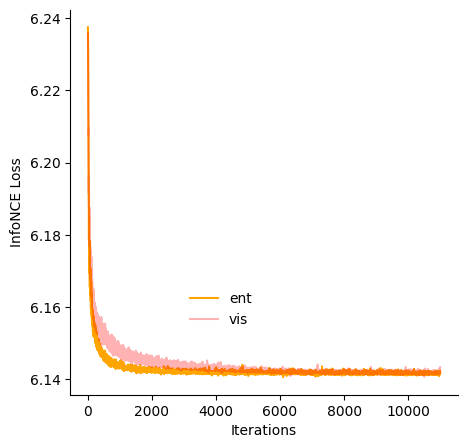

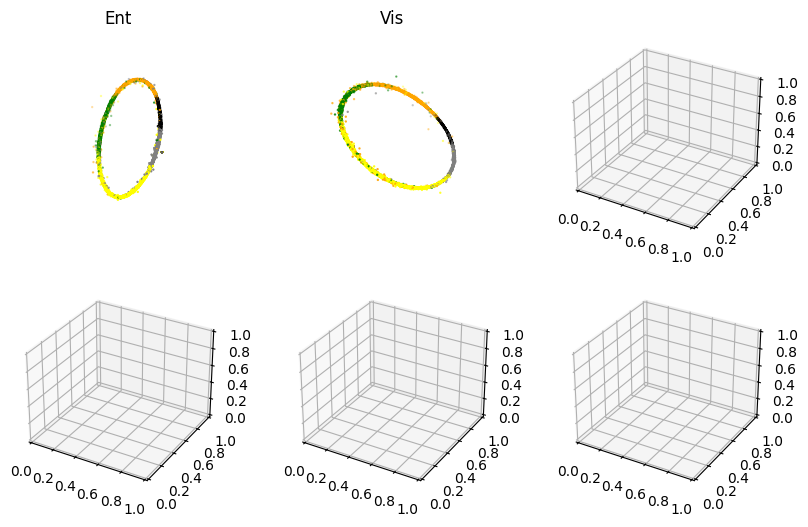

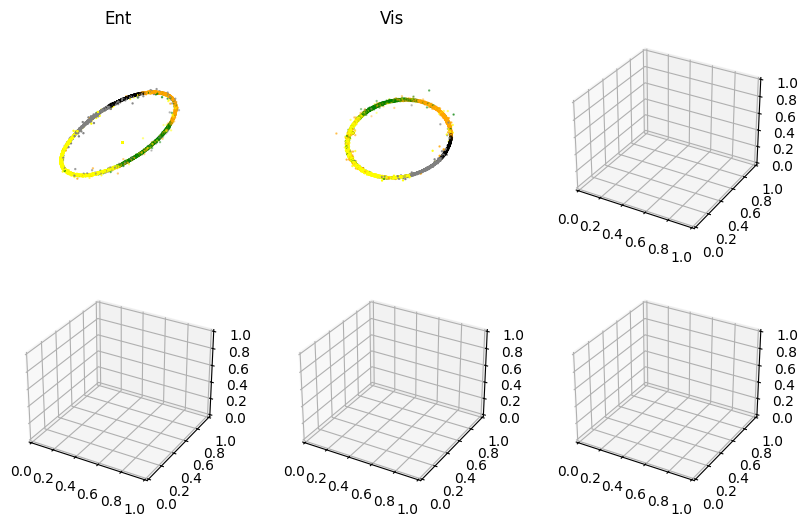

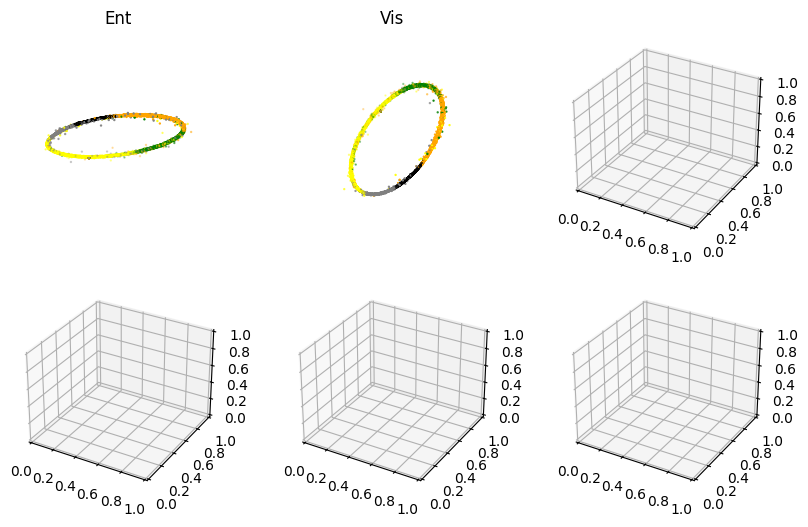

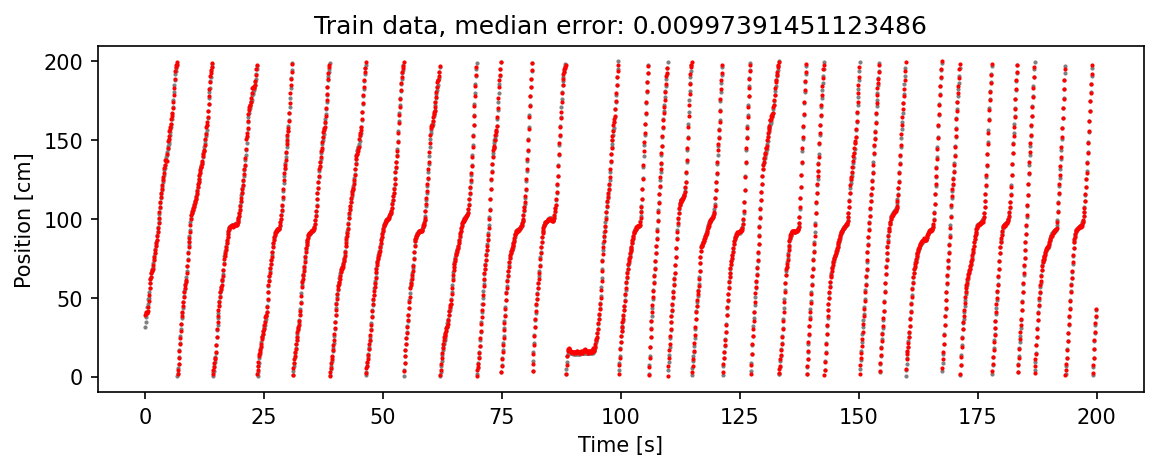

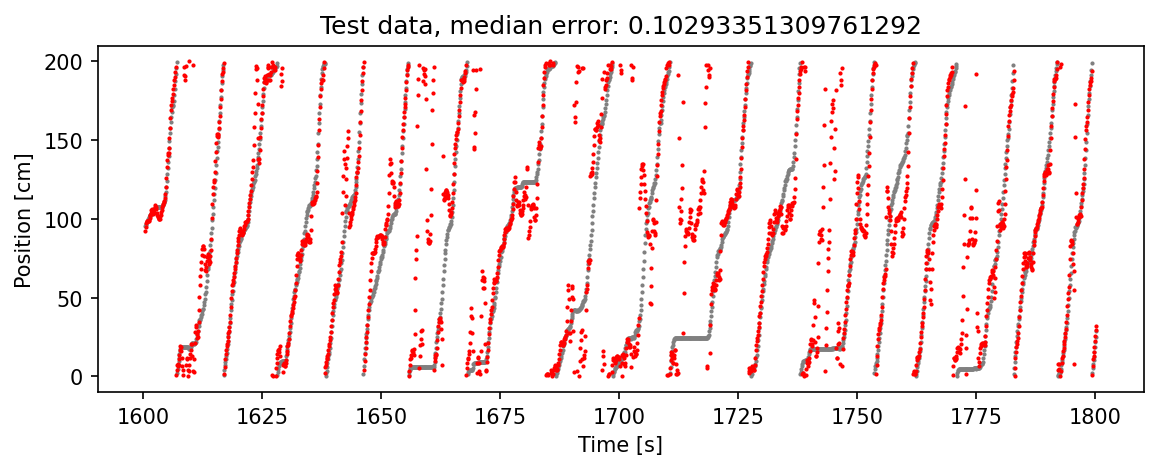

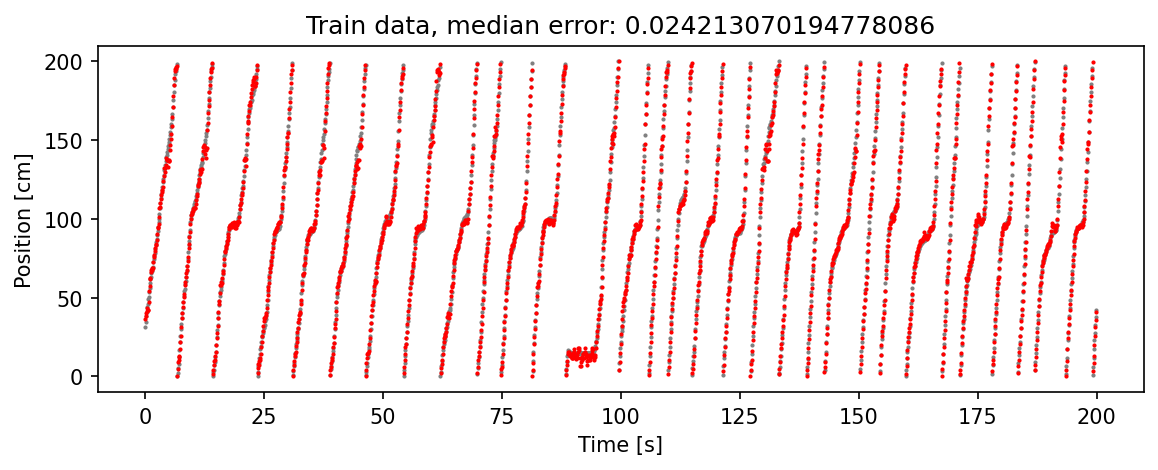

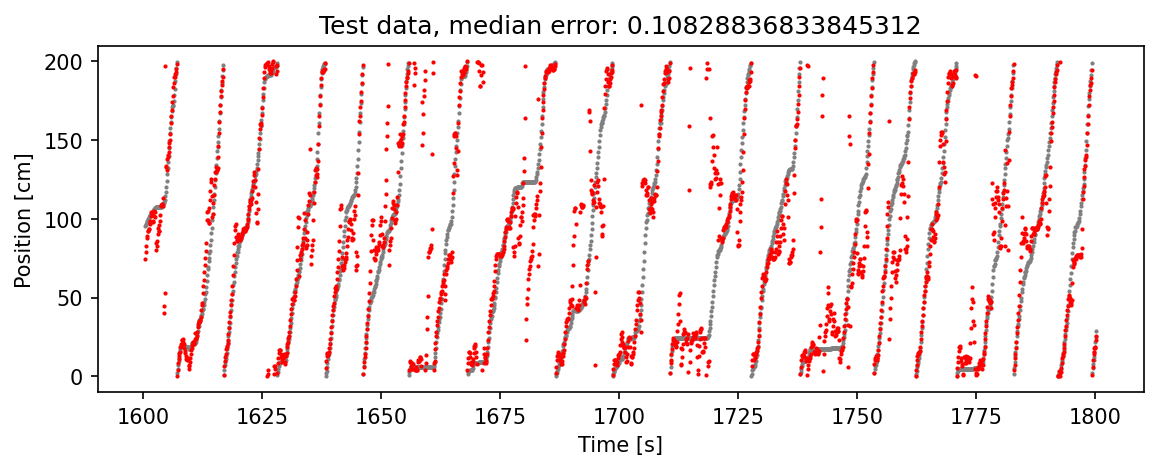

In [5]:
of_session_base_names = ["M21_D23_2024-05-25_16-07-17_OF1"]
vr_session_base_names = ["M21_D23_2024-05-25_16-54-12_VR1"]


for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    spike_data, position_data, processed_position_data = get_data(vr_name=vr_name, of_name=of_name)
    entorhinal_data = spike_data[spike_data["unit_location_y"] < 2200]
    visual_data = spike_data[spike_data["unit_location_y"] > 2200]

    entorhinal_fr_time_binned = extract_fr_column(entorhinal_data, column="fr_time_binned")
    entorhinal_x_time_binned = extract_fr_column(entorhinal_data, column="fr_time_binned_bin_centres")
    entorhinal_fr_time_binned = np.transpose(entorhinal_fr_time_binned)
    entorhinal_x_time_binned = np.transpose(entorhinal_x_time_binned)

    visual_fr_time_binned = extract_fr_column(visual_data, column="fr_time_binned")
    visual_x_time_binned = extract_fr_column(visual_data, column="fr_time_binned_bin_centres")
    visual_fr_time_binned = np.transpose(visual_fr_time_binned)
    visual_x_time_binned = np.transpose(visual_x_time_binned)

    behavioural_data =  computer_behaviour_kinematics(position_data, 
                                                      xnew_length=len(visual_x_time_binned[:,0]),
                                                      xnew_time_bin_size=settings.time_bin_size, 
                                                      track_length=200)

    x_position_cm = np.array(behavioural_data["x_position_cm"])
    speed = np.array(behavioural_data["speed"]); speed = speed/np.max(speed)
    acceleration = np.array(behavioural_data["acceleration"])
    trial_numbers = np.array(behavioural_data["trial_numbers"])
    time_seconds = np.array(behavioural_data["time_seconds"])
    x_position_cm_xy_cyc = encode_1d_to_2d(positions=x_position_cm)
    x_position_cm_x_cyc = x_position_cm_xy_cyc[:,0]
    x_position_cm_y_cyc = x_position_cm_xy_cyc[:,1]
    all_behaviour = np.stack([x_position_cm, x_position_cm_x_cyc, x_position_cm_y_cyc, 
                              speed, acceleration, trial_numbers, time_seconds], axis=0)
    all_behaviour = np.transpose(all_behaviour)

    max_i = 11000
    dims = 32  # here, we set as a variable for hypothesis testing below.

    # build entorhinal behaviour models
    entorhinal_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                           temperature=10, output_dimension=dims, max_iterations=max_i,
                           distance='cosine', conditional='time_delta',  device='cuda_if_available',
                           verbose=True, time_offsets=1)

    visual_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)

    # make training and testing data
    entorhinal_neural_train, entorhinal_neural_test, entorhinal_label_train, entorhinal_label_test = split_data(entorhinal_fr_time_binned, all_behaviour, 0.2)
    visual_neural_train, visual_neural_test, visual_label_train, visual_label_test = split_data(visual_fr_time_binned, all_behaviour, 0.2)

    # train models
    entorhinal_position_model.fit(entorhinal_neural_train, entorhinal_label_train[:, 1:3])
    visual_position_model.fit(visual_neural_train, visual_label_train[:, 1:4])
    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(111)
    ax.plot(entorhinal_position_model.state_dict_['loss'], c='orange', alpha=1, label='ent')
    ax.plot(visual_position_model.state_dict_['loss'], c='red', alpha=0.3, label='vis')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('InfoNCE Loss')
    plt.legend(bbox_to_anchor=(0.5, 0.3), frameon=False)
    plt.show()

    #plot embeddings
    entorhinal_position_embedding = entorhinal_position_model.transform(entorhinal_fr_time_binned)
    visual_position_speed_embedding = visual_position_model.transform(visual_fr_time_binned)
    
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=0)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=0)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()

    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()
    
    # plot decoding of entorhinal_ position model
    entorhinal_position_train = entorhinal_position_model.transform(entorhinal_neural_train)
    entorhinal_position_test = entorhinal_position_model.transform(entorhinal_neural_test)

    entorhinal_position_decoded_train = decoding_pos(entorhinal_position_train, entorhinal_position_train, entorhinal_label_train[:, 1:3])
    entorhinal_position_decoded_test = decoding_pos(entorhinal_position_train, entorhinal_position_test, entorhinal_label_train[:, 1:3])
    entorhinal_original_train = decode_2d_to_1d(entorhinal_label_train[:,1:3])
    entorhinal_original_test = decode_2d_to_1d(entorhinal_label_test[:,1:3])
    entorhinal_position_decoded_train_1d = decode_2d_to_1d(entorhinal_position_decoded_train)
    entorhinal_position_decoded_test_1d = decode_2d_to_1d(entorhinal_position_decoded_test)

    entorhinal_pos_train_err = np.median(abs(entorhinal_position_decoded_train - entorhinal_label_train[:,1:3]))
    entorhinal_pos_test_err = np.median(abs(entorhinal_position_decoded_test - entorhinal_label_test[:,1:3]))


    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(entorhinal_label_train[:n_samples, 6], entorhinal_original_train[:n_samples], c='gray', s=1)
    ax.scatter(entorhinal_label_train[:n_samples, 6], entorhinal_position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Train data, median error: {entorhinal_pos_train_err}")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(entorhinal_label_test[:n_samples, 6], entorhinal_original_test[:n_samples], c='gray', s=1)
    ax.scatter(entorhinal_label_test[:n_samples, 6], entorhinal_position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Test data, median error: {entorhinal_pos_test_err}")
    plt.show()

    
    # plot decoding of entorhinal_ position model
    visual_position_train = visual_position_model.transform(visual_neural_train)
    visual_position_test = visual_position_model.transform(visual_neural_test)

    visual_position_decoded_train = decoding_pos(visual_position_train, visual_position_train, visual_label_train[:, 1:3])
    visual_position_decoded_test = decoding_pos(visual_position_train, visual_position_test, visual_label_train[:, 1:3])
    visual_original_train = decode_2d_to_1d(visual_label_train[:,1:3])
    visual_original_test = decode_2d_to_1d(visual_label_test[:,1:3])
    visual_position_decoded_train_1d = decode_2d_to_1d(visual_position_decoded_train)
    visual_position_decoded_test_1d = decode_2d_to_1d(visual_position_decoded_test)
    
    visual_pos_train_err = np.median(abs(visual_position_decoded_train - visual_label_train[:,1:3]))
    visual_pos_test_err = np.median(abs(visual_position_decoded_test - visual_label_test[:,1:3]))

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(visual_label_train[:n_samples, 6], visual_original_train[:n_samples], c='gray', s=1)
    ax.scatter(visual_label_train[:n_samples, 6], visual_position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Train data, median error: {visual_pos_train_err}")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(visual_label_test[:n_samples, 6], visual_original_test[:n_samples], c='gray', s=1)
    ax.scatter(visual_label_test[:n_samples, 6], visual_position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Test data, median error: {visual_pos_test_err}")
    plt.show()




#### against but train on beaconed and test on non-beaconed

In [13]:
def split_data_by_tt(neural_data, label_data):
    beaconed_mask = label_data[: , 7] == 0
    non_beaconed_mask = label_data[: , 7] == 1
    neural_train = neural_data[beaconed_mask, :]
    neural_test = neural_data[non_beaconed_mask, :]
    label_train = label_data[beaconed_mask, :]
    label_test = label_data[non_beaconed_mask, :]

    return neural_train, neural_test, label_train, label_test
    

pos: -0.0974 neg:  6.2409 total:  6.1435 temperature:  10.0000: 100%|██████████| 11000/11000 [11:42<00:00, 15.66it/s]
pos: -0.0953 neg:  6.2408 total:  6.1455 temperature:  10.0000: 100%|██████████| 11000/11000 [11:05<00:00, 16.54it/s]


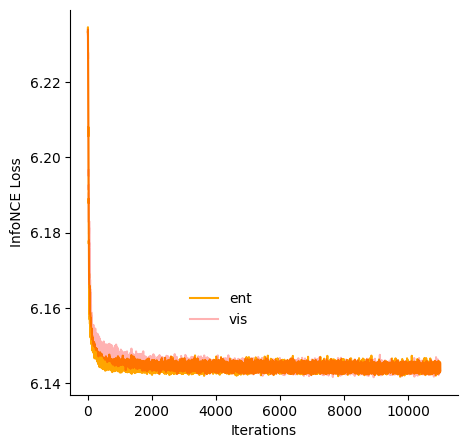

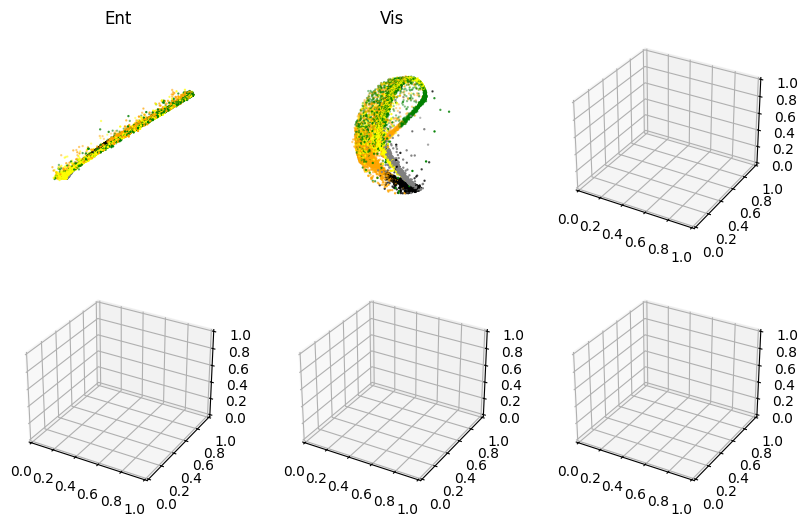

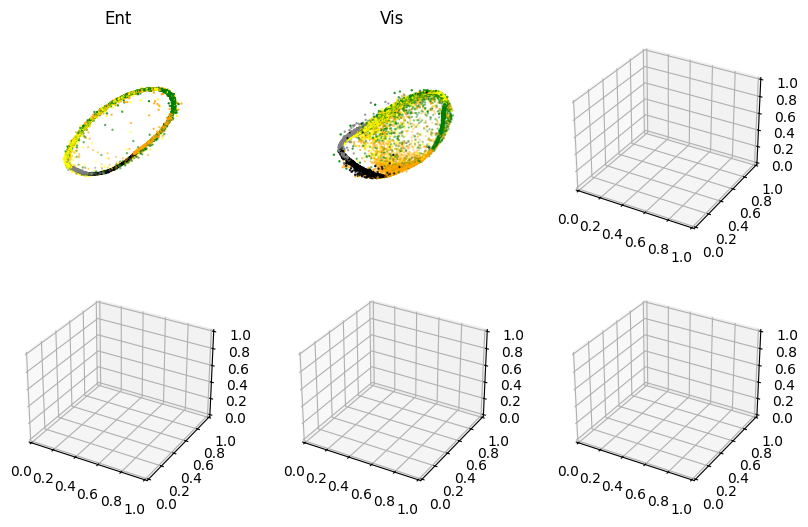

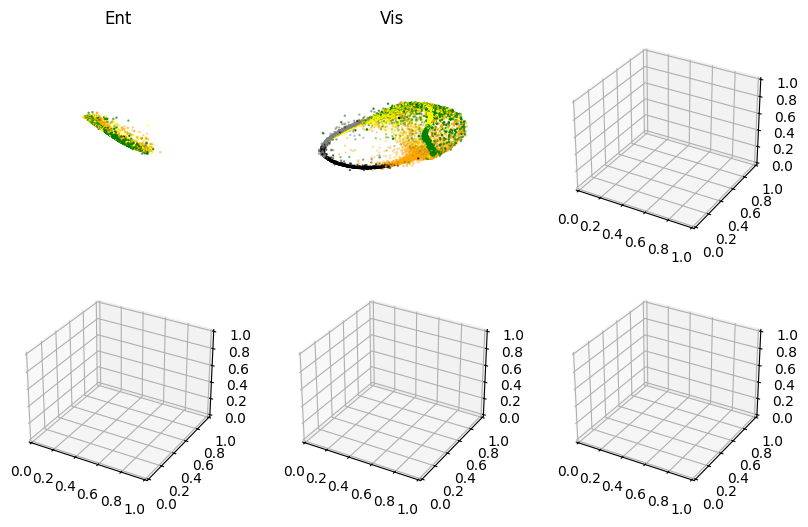

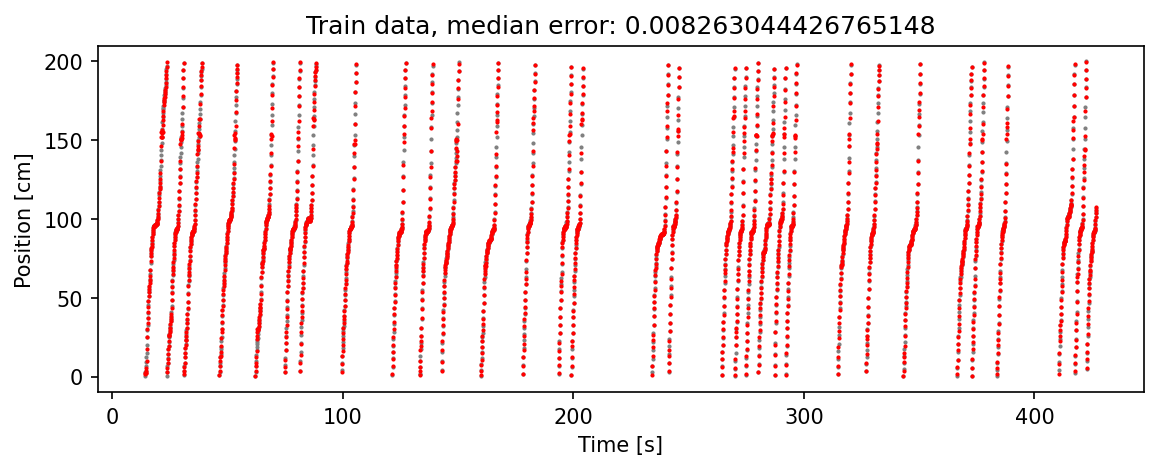

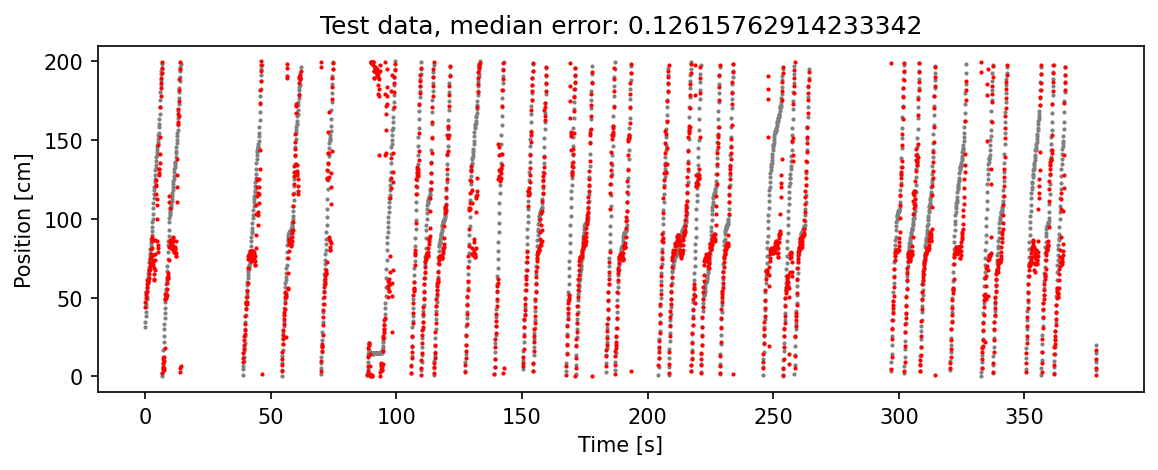

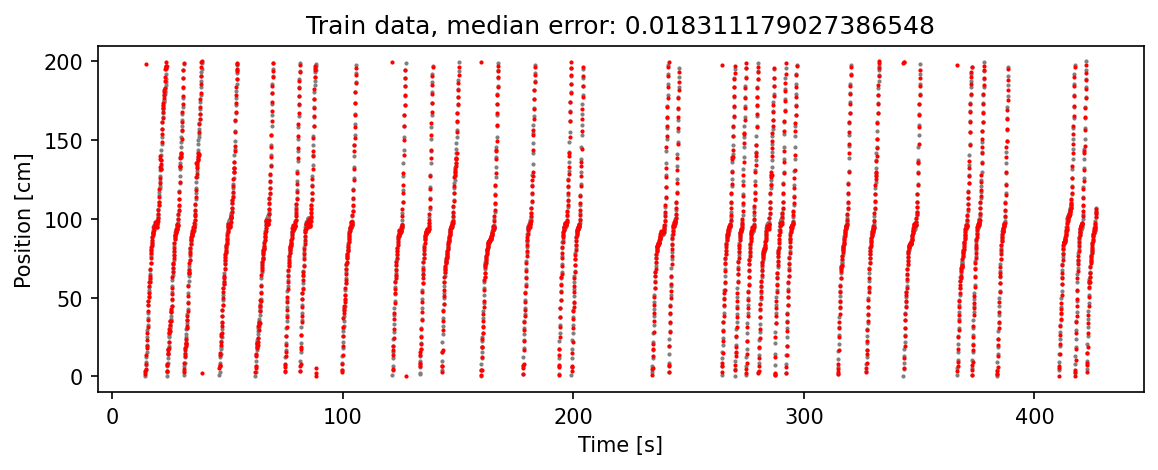

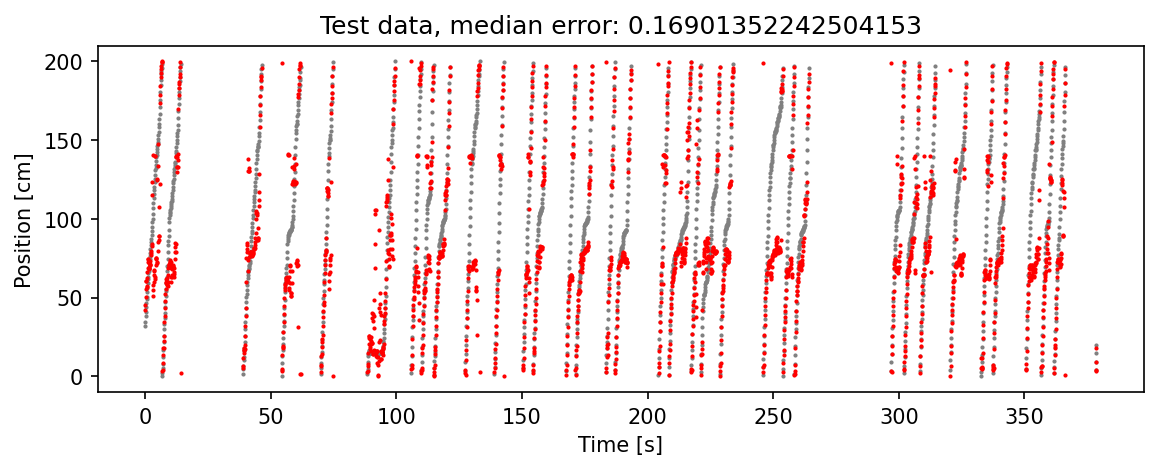

In [14]:
of_session_base_names = ["M21_D23_2024-05-25_16-07-17_OF1"]
vr_session_base_names = ["M21_D23_2024-05-25_16-54-12_VR1"]


for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    spike_data, position_data, processed_position_data = get_data(vr_name=vr_name, of_name=of_name)
    entorhinal_data = spike_data[spike_data["unit_location_y"] < 2200]
    visual_data = spike_data[spike_data["unit_location_y"] > 2200]

    entorhinal_fr_time_binned = extract_fr_column(entorhinal_data, column="fr_time_binned")
    entorhinal_x_time_binned = extract_fr_column(entorhinal_data, column="fr_time_binned_bin_centres")
    entorhinal_fr_time_binned = np.transpose(entorhinal_fr_time_binned)
    entorhinal_x_time_binned = np.transpose(entorhinal_x_time_binned)

    visual_fr_time_binned = extract_fr_column(visual_data, column="fr_time_binned")
    visual_x_time_binned = extract_fr_column(visual_data, column="fr_time_binned_bin_centres")
    visual_fr_time_binned = np.transpose(visual_fr_time_binned)
    visual_x_time_binned = np.transpose(visual_x_time_binned)

    behavioural_data =  computer_behaviour_kinematics(position_data, 
                                                      xnew_length=len(visual_x_time_binned[:,0]),
                                                      xnew_time_bin_size=settings.time_bin_size, 
                                                      track_length=200)

    x_position_cm = np.array(behavioural_data["x_position_cm"])
    speed = np.array(behavioural_data["speed"]); speed = speed/np.max(speed)
    acceleration = np.array(behavioural_data["acceleration"])
    trial_numbers = np.array(behavioural_data["trial_numbers"])
    time_seconds = np.array(behavioural_data["time_seconds"])
    trial_types = np.array(behavioural_data["trial_types"])

    x_position_cm_xy_cyc = encode_1d_to_2d(positions=x_position_cm)
    x_position_cm_x_cyc = x_position_cm_xy_cyc[:,0]
    x_position_cm_y_cyc = x_position_cm_xy_cyc[:,1]
    all_behaviour = np.stack([x_position_cm, x_position_cm_x_cyc, x_position_cm_y_cyc, 
                              speed, acceleration, trial_numbers, time_seconds, trial_types], axis=0)
    all_behaviour = np.transpose(all_behaviour)

    max_i = 11000
    dims = 32  # here, we set as a variable for hypothesis testing below.

    # build entorhinal behaviour models
    entorhinal_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                           temperature=10, output_dimension=dims, max_iterations=max_i,
                           distance='cosine', conditional='time_delta',  device='cuda_if_available',
                           verbose=True, time_offsets=1)

    visual_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)

    # make training and testing data
    entorhinal_neural_train, entorhinal_neural_test, entorhinal_label_train, entorhinal_label_test = split_data_by_tt(entorhinal_fr_time_binned, all_behaviour)
    visual_neural_train, visual_neural_test, visual_label_train, visual_label_test = split_data_by_tt(visual_fr_time_binned, all_behaviour)

    # train models
    entorhinal_position_model.fit(entorhinal_neural_train, entorhinal_label_train[:, 1:3])
    visual_position_model.fit(visual_neural_train, visual_label_train[:, 1:4])
    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(111)
    ax.plot(entorhinal_position_model.state_dict_['loss'], c='orange', alpha=1, label='ent')
    ax.plot(visual_position_model.state_dict_['loss'], c='red', alpha=0.3, label='vis')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('InfoNCE Loss')
    plt.legend(bbox_to_anchor=(0.5, 0.3), frameon=False)
    plt.show()

    #plot embeddings
    entorhinal_position_embedding = entorhinal_position_model.transform(entorhinal_fr_time_binned)
    visual_position_speed_embedding = visual_position_model.transform(visual_fr_time_binned)
    
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=0)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=0)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()

    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()
    
    # plot decoding of entorhinal_ position model
    entorhinal_position_train = entorhinal_position_model.transform(entorhinal_neural_train)
    entorhinal_position_test = entorhinal_position_model.transform(entorhinal_neural_test)

    entorhinal_position_decoded_train = decoding_pos(entorhinal_position_train, entorhinal_position_train, entorhinal_label_train[:, 1:3])
    entorhinal_position_decoded_test = decoding_pos(entorhinal_position_train, entorhinal_position_test, entorhinal_label_train[:, 1:3])
    entorhinal_original_train = decode_2d_to_1d(entorhinal_label_train[:,1:3])
    entorhinal_original_test = decode_2d_to_1d(entorhinal_label_test[:,1:3])
    entorhinal_position_decoded_train_1d = decode_2d_to_1d(entorhinal_position_decoded_train)
    entorhinal_position_decoded_test_1d = decode_2d_to_1d(entorhinal_position_decoded_test)

    entorhinal_pos_train_err = np.median(abs(entorhinal_position_decoded_train - entorhinal_label_train[:,1:3]))
    entorhinal_pos_test_err = np.median(abs(entorhinal_position_decoded_test - entorhinal_label_test[:,1:3]))


    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(entorhinal_label_train[:n_samples, 6], entorhinal_original_train[:n_samples], c='gray', s=1)
    ax.scatter(entorhinal_label_train[:n_samples, 6], entorhinal_position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Train data, median error: {entorhinal_pos_train_err}")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(entorhinal_label_test[:n_samples, 6], entorhinal_original_test[:n_samples], c='gray', s=1)
    ax.scatter(entorhinal_label_test[:n_samples, 6], entorhinal_position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Test data, median error: {entorhinal_pos_test_err}")
    plt.show()

    
    # plot decoding of entorhinal_ position model
    visual_position_train = visual_position_model.transform(visual_neural_train)
    visual_position_test = visual_position_model.transform(visual_neural_test)

    visual_position_decoded_train = decoding_pos(visual_position_train, visual_position_train, visual_label_train[:, 1:3])
    visual_position_decoded_test = decoding_pos(visual_position_train, visual_position_test, visual_label_train[:, 1:3])
    visual_original_train = decode_2d_to_1d(visual_label_train[:,1:3])
    visual_original_test = decode_2d_to_1d(visual_label_test[:,1:3])
    visual_position_decoded_train_1d = decode_2d_to_1d(visual_position_decoded_train)
    visual_position_decoded_test_1d = decode_2d_to_1d(visual_position_decoded_test)
    
    visual_pos_train_err = np.median(abs(visual_position_decoded_train - visual_label_train[:,1:3]))
    visual_pos_test_err = np.median(abs(visual_position_decoded_test - visual_label_test[:,1:3]))
    
    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(visual_label_train[:n_samples, 6], visual_original_train[:n_samples], c='gray', s=1)
    ax.scatter(visual_label_train[:n_samples, 6], visual_position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Train data, median error: {visual_pos_train_err}")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(visual_label_test[:n_samples, 6], visual_original_test[:n_samples], c='gray', s=1)
    ax.scatter(visual_label_test[:n_samples, 6], visual_position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Test data, median error: {visual_pos_test_err}")
    plt.show()




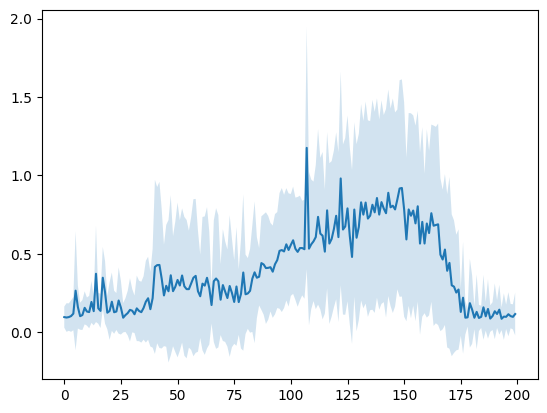

In [41]:
error_by_bin = []
std_by_bin = []
for bin in np.arange(0,200):
    bin_mask = (entorhinal_label_test[:, 0] > bin) & (entorhinal_label_test[:, 0] < (bin+1))

    error_for_bin = np.linalg.norm(entorhinal_position_decoded_test[bin_mask] - entorhinal_label_test[bin_mask,1:3], axis=1)
    error_by_bin.append(np.nanmean(error_for_bin))
    std_by_bin.append(np.nanstd(error_for_bin))
error_by_bin=np.array(error_by_bin)
std_by_bin=np.array(std_by_bin)
plt.plot(np.arange(0,200), error_by_bin)
plt.fill_between(np.arange(0,200), error_by_bin-std_by_bin, error_by_bin+std_by_bin, alpha=0.2)
plt.show()

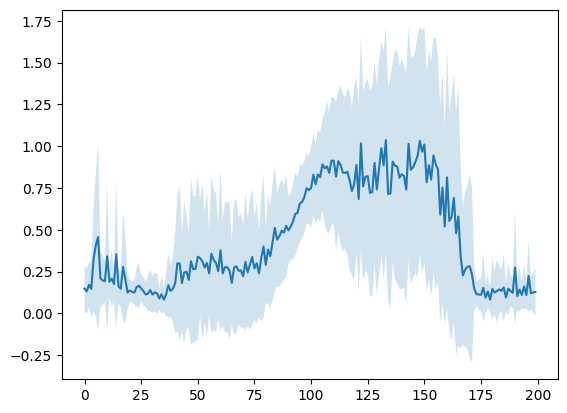

In [42]:
error_by_bin = []
std_by_bin = []
for bin in np.arange(0,200):
    bin_mask = (visual_label_test[:, 0] > bin) & (visual_label_test[:, 0] < (bin+1))

    error_for_bin = np.linalg.norm(visual_position_decoded_test[bin_mask] - visual_label_test[bin_mask,1:3], axis=1)
    error_by_bin.append(np.nanmean(error_for_bin))
    std_by_bin.append(np.nanstd(error_for_bin))
error_by_bin=np.array(error_by_bin)
std_by_bin=np.array(std_by_bin)
plt.plot(np.arange(0,200), error_by_bin)
plt.fill_between(np.arange(0,200), error_by_bin-std_by_bin, error_by_bin+std_by_bin, alpha=0.2)
plt.show()

#### now again but using the beacon trials as the test set and the non beaconed as the train set

In [43]:
def split_data_by_tt(neural_data, label_data):
    beaconed_mask = label_data[: , 7] == 0
    non_beaconed_mask = label_data[: , 7] == 1
    neural_train = neural_data[non_beaconed_mask, :]
    neural_test = neural_data[beaconed_mask, :]
    label_train = label_data[non_beaconed_mask, :]
    label_test = label_data[beaconed_mask, :]

    return neural_train, neural_test, label_train, label_test

pos: -0.0995 neg:  6.2409 total:  6.1414 temperature:  10.0000: 100%|██████████| 11000/11000 [12:56<00:00, 14.16it/s]
pos: -0.0986 neg:  6.2413 total:  6.1426 temperature:  10.0000: 100%|██████████| 11000/11000 [12:19<00:00, 14.87it/s]


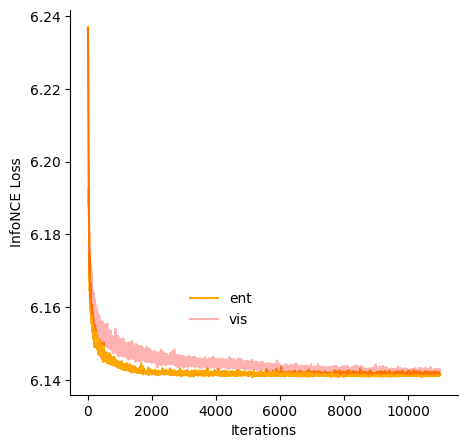

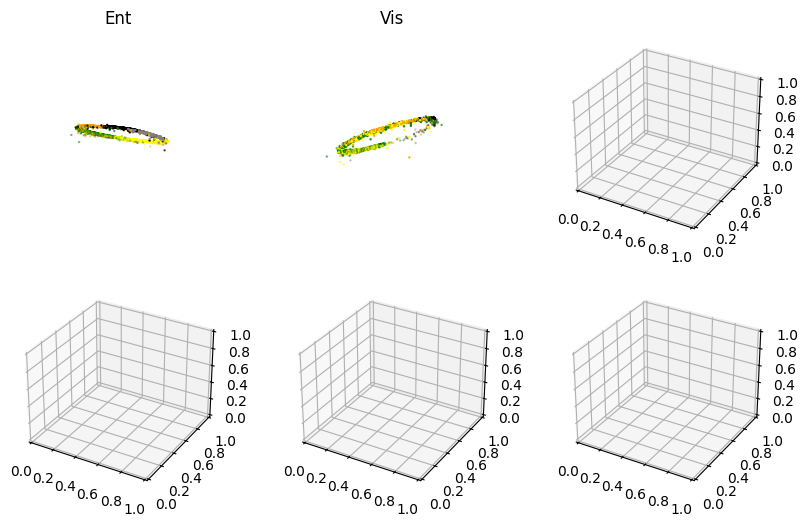

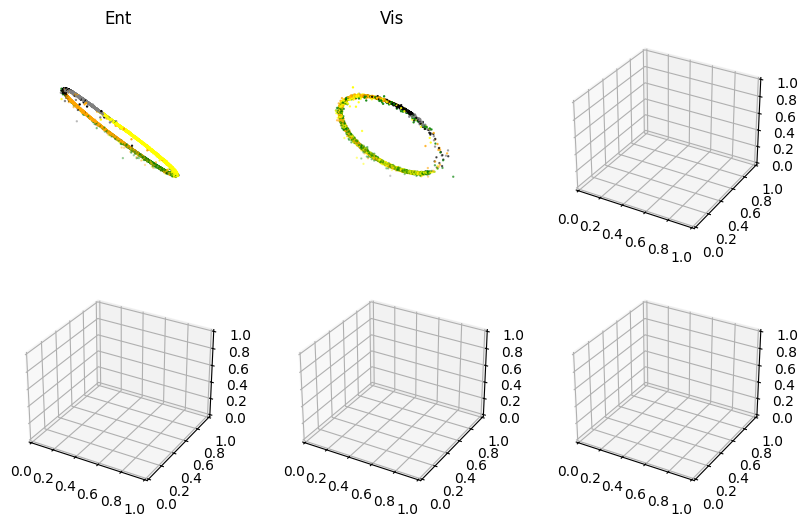

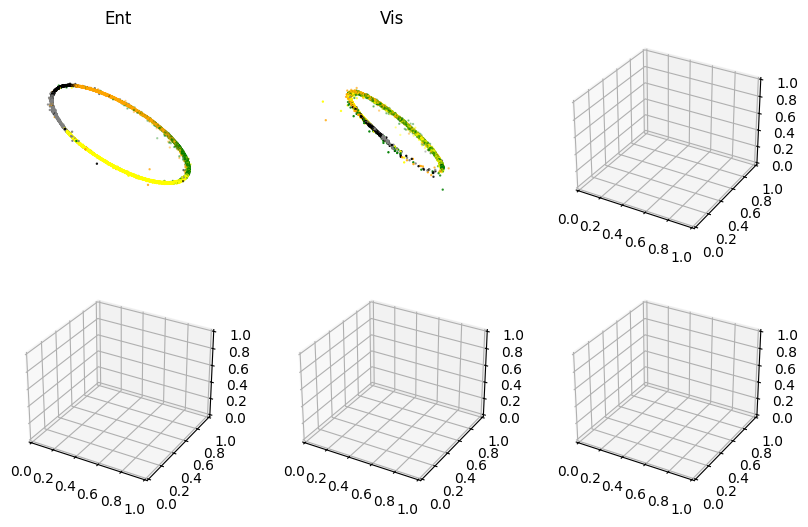

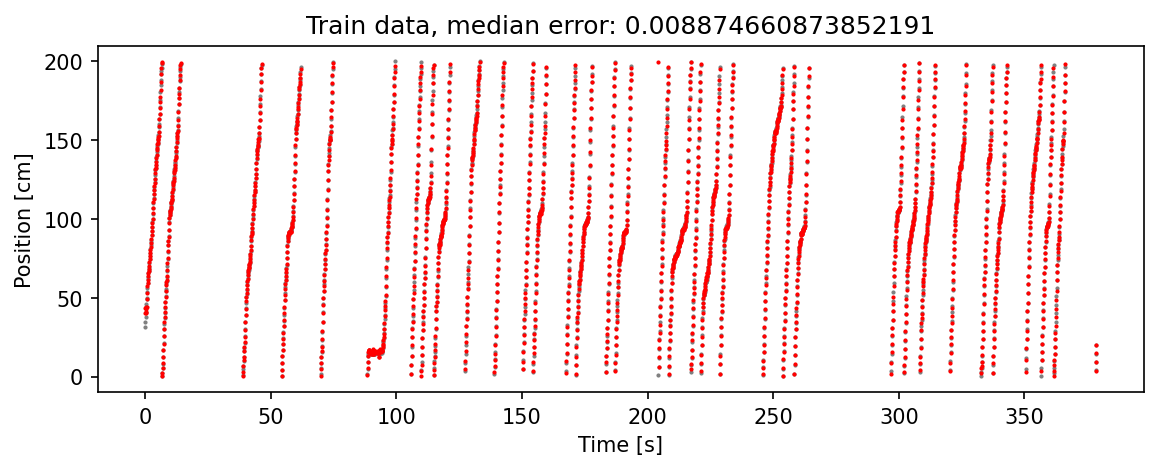

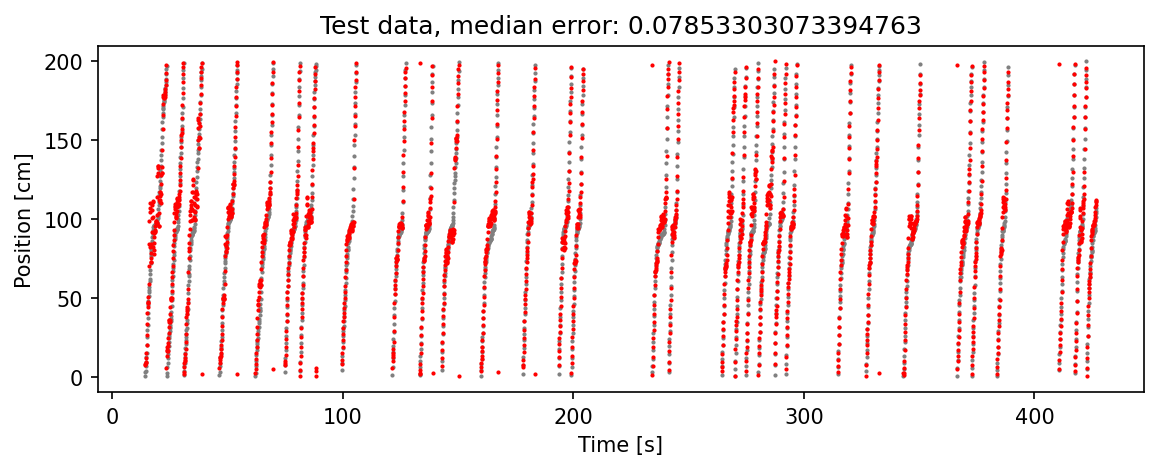

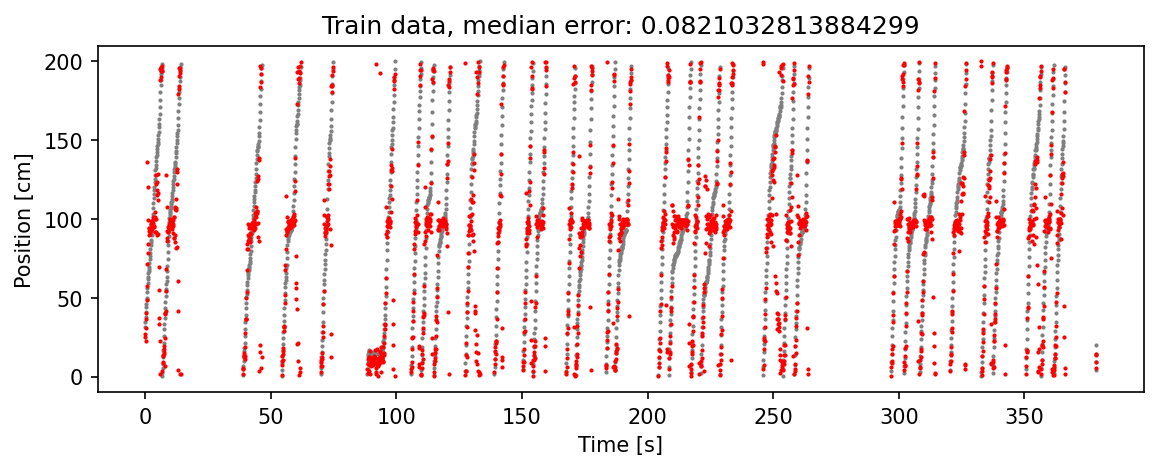

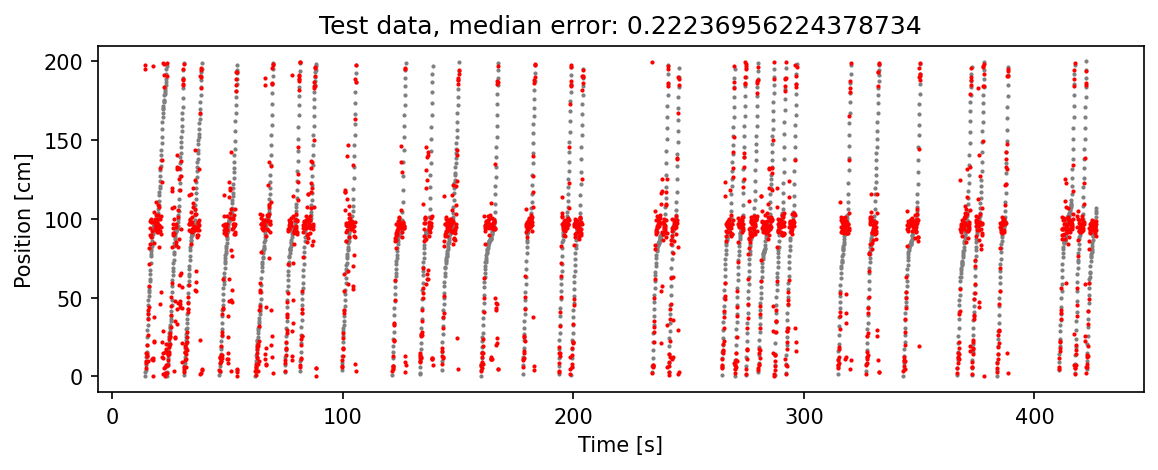

In [44]:
of_session_base_names = ["M21_D23_2024-05-25_16-07-17_OF1"]
vr_session_base_names = ["M21_D23_2024-05-25_16-54-12_VR1"]


for vr_name, of_name in zip(vr_session_base_names, of_session_base_names):
    spike_data, position_data, processed_position_data = get_data(vr_name=vr_name, of_name=of_name)
    entorhinal_data = spike_data[spike_data["unit_location_y"] < 2200]
    visual_data = spike_data[spike_data["unit_location_y"] > 2200]

    entorhinal_fr_time_binned = extract_fr_column(entorhinal_data, column="fr_time_binned")
    entorhinal_x_time_binned = extract_fr_column(entorhinal_data, column="fr_time_binned_bin_centres")
    entorhinal_fr_time_binned = np.transpose(entorhinal_fr_time_binned)
    entorhinal_x_time_binned = np.transpose(entorhinal_x_time_binned)

    visual_fr_time_binned = extract_fr_column(visual_data, column="fr_time_binned")
    visual_x_time_binned = extract_fr_column(visual_data, column="fr_time_binned_bin_centres")
    visual_fr_time_binned = np.transpose(visual_fr_time_binned)
    visual_x_time_binned = np.transpose(visual_x_time_binned)

    behavioural_data =  computer_behaviour_kinematics(position_data, 
                                                      xnew_length=len(visual_x_time_binned[:,0]),
                                                      xnew_time_bin_size=settings.time_bin_size, 
                                                      track_length=200)

    x_position_cm = np.array(behavioural_data["x_position_cm"])
    speed = np.array(behavioural_data["speed"]); speed = speed/np.max(speed)
    acceleration = np.array(behavioural_data["acceleration"])
    trial_numbers = np.array(behavioural_data["trial_numbers"])
    time_seconds = np.array(behavioural_data["time_seconds"])
    trial_types = np.array(behavioural_data["trial_types"])

    x_position_cm_xy_cyc = encode_1d_to_2d(positions=x_position_cm)
    x_position_cm_x_cyc = x_position_cm_xy_cyc[:,0]
    x_position_cm_y_cyc = x_position_cm_xy_cyc[:,1]
    all_behaviour = np.stack([x_position_cm, x_position_cm_x_cyc, x_position_cm_y_cyc, 
                              speed, acceleration, trial_numbers, time_seconds, trial_types], axis=0)
    all_behaviour = np.transpose(all_behaviour)

    max_i = 11000
    dims = 32  # here, we set as a variable for hypothesis testing below.

    # build entorhinal behaviour models
    entorhinal_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                           temperature=10, output_dimension=dims, max_iterations=max_i,
                           distance='cosine', conditional='time_delta',  device='cuda_if_available',
                           verbose=True, time_offsets=1)

    visual_position_model = CEBRA(model_architecture='offset10-model',batch_size=512, learning_rate=3e-4,
                        temperature=10, output_dimension=dims, max_iterations=max_i,
                        distance='cosine', conditional='time_delta',  device='cuda_if_available',
                        verbose=True, time_offsets=1)

    # make training and testing data
    entorhinal_neural_train, entorhinal_neural_test, entorhinal_label_train, entorhinal_label_test = split_data_by_tt(entorhinal_fr_time_binned, all_behaviour)
    visual_neural_train, visual_neural_test, visual_label_train, visual_label_test = split_data_by_tt(visual_fr_time_binned, all_behaviour)

    # train models
    entorhinal_position_model.fit(entorhinal_neural_train, entorhinal_label_train[:, 1:3])
    visual_position_model.fit(visual_neural_train, visual_label_train[:, 1:4])
    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(111)
    ax.plot(entorhinal_position_model.state_dict_['loss'], c='orange', alpha=1, label='ent')
    ax.plot(visual_position_model.state_dict_['loss'], c='red', alpha=0.3, label='vis')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('InfoNCE Loss')
    plt.legend(bbox_to_anchor=(0.5, 0.3), frameon=False)
    plt.show()

    #plot embeddings
    entorhinal_position_embedding = entorhinal_position_model.transform(entorhinal_fr_time_binned)
    visual_position_speed_embedding = visual_position_model.transform(visual_fr_time_binned)
    
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=0)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=0)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=1)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()

    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    ax3 = fig.add_subplot(2, 3, 3, projection="3d")
    ax4 = fig.add_subplot(2, 3, 4, projection="3d")
    ax5 = fig.add_subplot(2, 3, 5, projection="3d")
    ax6 = fig.add_subplot(2, 3, 6, projection="3d")
    ax1 = plot_embeddings(ax1, entorhinal_position_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax2 = plot_embeddings(ax2, visual_position_speed_embedding, x_position_cm, cmap="track", viewing_angle=2)
    ax1.set_title('Ent')
    ax2.set_title('Vis')
    plt.show()
    
    # plot decoding of entorhinal_ position model
    entorhinal_position_train = entorhinal_position_model.transform(entorhinal_neural_train)
    entorhinal_position_test = entorhinal_position_model.transform(entorhinal_neural_test)

    entorhinal_position_decoded_train = decoding_pos(entorhinal_position_train, entorhinal_position_train, entorhinal_label_train[:, 1:3])
    entorhinal_position_decoded_test = decoding_pos(entorhinal_position_train, entorhinal_position_test, entorhinal_label_train[:, 1:3])
    entorhinal_original_train = decode_2d_to_1d(entorhinal_label_train[:,1:3])
    entorhinal_original_test = decode_2d_to_1d(entorhinal_label_test[:,1:3])
    entorhinal_position_decoded_train_1d = decode_2d_to_1d(entorhinal_position_decoded_train)
    entorhinal_position_decoded_test_1d = decode_2d_to_1d(entorhinal_position_decoded_test)

    entorhinal_pos_train_err = np.median(abs(entorhinal_position_decoded_train - entorhinal_label_train[:,1:3]))
    entorhinal_pos_test_err = np.median(abs(entorhinal_position_decoded_test - entorhinal_label_test[:,1:3]))


    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(entorhinal_label_train[:n_samples, 6], entorhinal_original_train[:n_samples], c='gray', s=1)
    ax.scatter(entorhinal_label_train[:n_samples, 6], entorhinal_position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Train data, median error: {entorhinal_pos_train_err}")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(entorhinal_label_test[:n_samples, 6], entorhinal_original_test[:n_samples], c='gray', s=1)
    ax.scatter(entorhinal_label_test[:n_samples, 6], entorhinal_position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Test data, median error: {entorhinal_pos_test_err}")
    plt.show()

    
    # plot decoding of entorhinal_ position model
    visual_position_train = visual_position_model.transform(visual_neural_train)
    visual_position_test = visual_position_model.transform(visual_neural_test)

    visual_position_decoded_train = decoding_pos(visual_position_train, visual_position_train, visual_label_train[:, 1:3])
    visual_position_decoded_test = decoding_pos(visual_position_train, visual_position_test, visual_label_train[:, 1:3])
    visual_original_train = decode_2d_to_1d(visual_label_train[:,1:3])
    visual_original_test = decode_2d_to_1d(visual_label_test[:,1:3])
    visual_position_decoded_train_1d = decode_2d_to_1d(visual_position_decoded_train)
    visual_position_decoded_test_1d = decode_2d_to_1d(visual_position_decoded_test)
    
    visual_pos_train_err = np.median(abs(visual_position_decoded_train - visual_label_train[:,1:3]))
    visual_pos_test_err = np.median(abs(visual_position_decoded_test - visual_label_test[:,1:3]))
    
    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(visual_label_train[:n_samples, 6], visual_original_train[:n_samples], c='gray', s=1)
    ax.scatter(visual_label_train[:n_samples, 6], visual_position_decoded_train_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Train data, median error: {visual_pos_train_err}")
    plt.show()

    fig = plt.figure(figsize=(9, 3), dpi=150)
    plt.subplots_adjust(wspace=0.3)
    ax = plt.subplot(111)
    n_samples = 2000
    ax.scatter(visual_label_test[:n_samples, 6], visual_original_test[:n_samples], c='gray', s=1)
    ax.scatter(visual_label_test[:n_samples, 6], visual_position_decoded_test_1d[:n_samples], c='red', s=1)
    plt.ylabel('Position [cm]')
    plt.xlabel('Time [s]')
    plt.title(f"Test data, median error: {visual_pos_test_err}")
    plt.show()




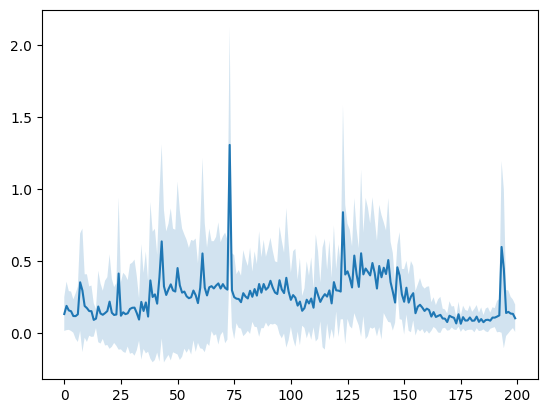

In [45]:
error_by_bin = []
std_by_bin = []
for bin in np.arange(0,200):
    bin_mask = (entorhinal_label_test[:, 0] > bin) & (entorhinal_label_test[:, 0] < (bin+1))

    error_for_bin = np.linalg.norm(entorhinal_position_decoded_test[bin_mask] - entorhinal_label_test[bin_mask,1:3], axis=1)
    error_by_bin.append(np.nanmean(error_for_bin))
    std_by_bin.append(np.nanstd(error_for_bin))
error_by_bin=np.array(error_by_bin)
std_by_bin=np.array(std_by_bin)
plt.plot(np.arange(0,200), error_by_bin)
plt.fill_between(np.arange(0,200), error_by_bin-std_by_bin, error_by_bin+std_by_bin, alpha=0.2)
plt.show()

In [3]:
error_by_bin = []
std_by_bin = []
for bin in np.arange(0,200):
    bin_mask = (visual_label_test[:, 0] > bin) & (visual_label_test[:, 0] < (bin+1))

    error_for_bin = np.linalg.norm(visual_position_decoded_test[bin_mask] - visual_label_test[bin_mask,1:3], axis=1)
    error_by_bin.append(np.nanmean(error_for_bin))
    std_by_bin.append(np.nanstd(error_for_bin))
error_by_bin=np.array(error_by_bin)
std_by_bin=np.array(std_by_bin)

spikes_on_track = plt.figure()
spikes_on_track.set_size_inches(5, 5/3, forward=True)
ax = spikes_on_track.add_subplot(1, 1, 1)
plot_utility.style_track_plot(ax, 200, alpha=0.15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(np.arange(0,200), error_by_bin)
plt.fill_between(np.arange(0,200), error_by_bin-std_by_bin, error_by_bin+std_by_bin, alpha=0.2)
plt.show()

NameError: name 'visual_label_test' is not defined